In [130]:
import pandas as pd
import numpy as np
import pickle

In [131]:
train_region = "SanDiego"
test_region = "Austin"
out_overall = pickle.load(open('../data/input/all_regions.pkl','r'))

train_df = out_overall[train_region]
test_df = out_overall[test_region]
transform = "DD"
k=3

In [141]:
out = {}
for transform in ["DD","None"]:
    out[transform] = {}
    for appliance in ["hvac","fridge","dr","wm"]:
        out[transform][appliance] = {}
        for month in range(1,13):
            print appliance, month, transform
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                    if percentage_error>100:
                        percentage_error=100
                    percentage_accuracy = 100-percentage_error
                    out[transform][appliance][month].append(percentage_accuracy)
                except Exception, e:
                    pass

            


hvac 1 DD
hvac 2 DD
hvac 3 DD
hvac 4 DD
hvac 5 DD
hvac 6 DD
hvac 7 DD
hvac 8 DD
hvac 9 DD
hvac 10 DD
hvac 11 DD
hvac 12 DD
fridge 1 DD
fridge 2 DD
fridge 3 DD
fridge 4 DD
fridge 5 DD
fridge 6 DD
fridge 7 DD
fridge 8 DD
fridge 9 DD
fridge 10 DD
fridge 11 DD
fridge 12 DD
dr 1 DD
dr 2 DD
dr 3 DD
dr 4 DD
dr 5 DD
dr 6 DD
dr 7 DD
dr 8 DD
dr 9 DD
dr 10 DD
dr 11 DD
dr 12 DD
wm 1 DD
wm 2 DD
wm 3 DD
wm 4 DD
wm 5 DD
wm 6 DD
wm 7 DD
wm 8 DD
wm 9 DD
wm 10 DD
wm 11 DD
wm 12 DD
hvac 1 None
hvac 2 None
hvac 3 None
hvac 4 None
hvac 5 None
hvac 6 None
hvac 7 None
hvac 8 None
hvac 9 None
hvac 10 None
hvac 11 None
hvac 12 None
fridge 1 None
fridge 2 None
fridge 3 None
fridge 4 None
fridge 5 None
fridge 6 None
fridge 7 None
fridge 8 None
fridge 9 None
fridge 10 None
fridge 11 None
fridge 12 None
dr 1 None
dr 2 None
dr 3 None
dr 4 None
dr 5 None
dr 6 None
dr 7 None
dr 8 None
dr 9 None
dr 10 None
dr 11 None
dr 12 None
wm 1 None
wm 2 None
wm 3 None
wm 4 None
wm 5 None
wm 6 None
wm 7 None
wm 8 None
wm 9 None
w

In [146]:
acc = {'None':{},'Regional average':{}, 'DD':{}}

In [147]:
for transform in ['DD','None']:
    for appliance in ["hvac","fridge","wm"]:
        acc[transform][appliance] = {}
        for month in range(1,13):
            acc[transform][appliance][month] = pd.Series(out[transform][appliance][month]).mean()

In [135]:
%matplotlib inline

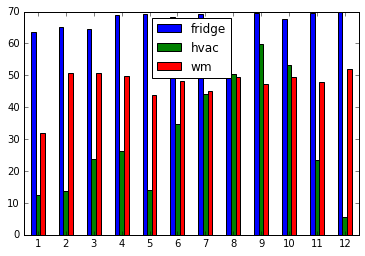

In [149]:
pd.DataFrame(acc['None']).plot(kind='bar',rot=0)

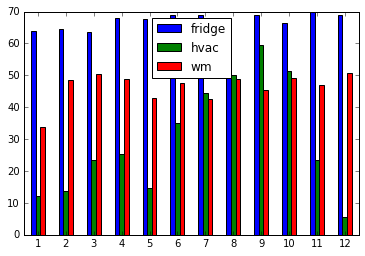

In [65]:
pd.DataFrame(acc['Our approach']).plot(kind='bar',rot=0)

In [137]:
contri = {
    'Austin':
    {'wm':0.01,
    'hvac':0.29,
    'fridge':0.09}
}

In [155]:
for appliance in ["hvac","fridge","wm"]:
    acc['Regional average'][appliance] = {}
    for month in range(1,13):
        acc['Regional average'][appliance][month] = []
        for test_home in test_df.index:
            try:
                pred = test_df.ix[test_home]['aggregate_%d' %month]*contri[test_region][appliance]
                gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                error = np.abs(gt-pred)
                percentage_error = error*100/gt
                if percentage_error>100:
                    percentage_error=100
                percentage_accuracy = 100-percentage_error
                acc['Regional average'][appliance][month].append(percentage_accuracy)
            except Exception, e:
                print e
                
        acc['Regional average'][appliance][month] = pd.Series(acc['Regional average'][appliance][month]).mean()

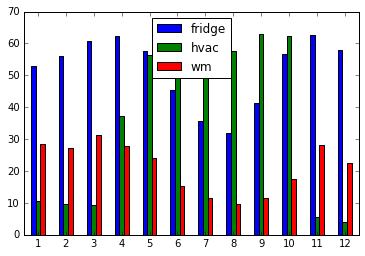

In [139]:
pd.DataFrame(acc['Regional average']).plot(kind='bar',rot=0)

In [70]:
import matplotlib.pyplot as plt

In [154]:
acc['Regional average'].keys()

[]

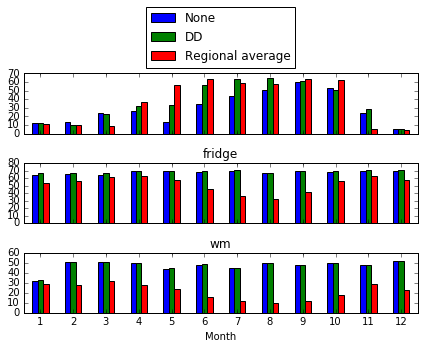

In [159]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for i, appliance in enumerate(["hvac","fridge","wm"]):
    ap_dict = {approach:acc[approach][appliance] for approach in acc.keys()}
    df = pd.DataFrame(ap_dict)
    df = df[['None','DD','Regional average']]
    df.plot(ax=ax[i], kind='bar', title=appliance, rot= 0, legend=False)
plt.tight_layout()
lgd=ax[0].legend(bbox_to_anchor=(0.5,2.2), loc='upper center', ncol=1)
plt.xlabel("Month")
plt.savefig('../results/dd_transform_sd_austin.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

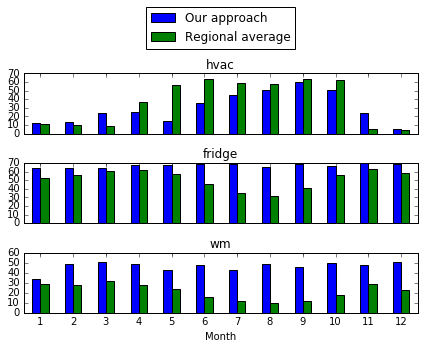

In [157]:
from IPython.display import Image
Image('../results/no_transform_sd_austin.png')

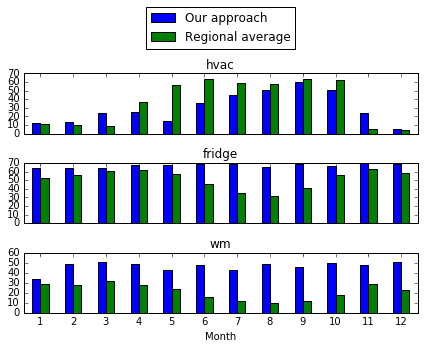

In [119]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for i, appliance in enumerate(["hvac","fridge","wm"]):
    ap_dict = {approach:acc[approach][appliance] for approach in acc.keys()}
    df = pd.DataFrame(ap_dict)
    df.plot(ax=ax[i], kind='bar', title=appliance, rot= 0, legend=False)
plt.tight_layout()
lgd=ax[0].legend(bbox_to_anchor=(0.5,2.2), loc='upper center', ncol=1)
plt.xlabel("Month")
#

#plt.savefig('../results/no_transform_sd_austin.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [73]:
ap_dict

{'Our approach': {1: 33.8734504582082,
  2: 48.67136857405774,
  3: 50.31158734130758,
  4: 48.937788635189555,
  5: 42.91586645201225,
  6: 47.54102296541092,
  7: 42.690949812235495,
  8: 48.85646634271478,
  9: 45.31713598166896,
  10: 49.332064873332705,
  11: 47.12320106158118,
  12: 50.861510015694236},
 'Regional average': {1: 33.8734504582082,
  2: 48.67136857405774,
  3: 50.31158734130758,
  4: 48.937788635189555,
  5: 42.91586645201225,
  6: 47.54102296541092,
  7: 42.690949812235495,
  8: 48.85646634271478,
  9: 45.31713598166896,
  10: 49.332064873332705,
  11: 47.12320106158118,
  12: 50.861510015694236}}

In [77]:
acc['Regional average']

{'fridge': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []},
 'hvac': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []},
 'wm': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []}}

In [129]:
train_df['hvac_9'].mean()

218.4750300575705

In [128]:
test_df['hvac_9'].mean()

482.0247721723813

In [175]:
m = {}
for transform in ["DD","None"]:
    m[transform] = {}
    for appliance in ["hvac"]:
       
        for month in range(1,13):
            m[transform][month]=[]
            
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                    if percentage_error>100:
                        percentage_error=100
                    percentage_accuracy = 100-percentage_error
                    #print appliance, month, transform, gt-pred
                    m[transform][month].append(gt-pred)
                except Exception, e:
                    pass

            


In [176]:
pd.Series(m['DD'][7]).describe()

count     368.000000
mean      168.770760
std       278.876247
min      -671.245708
25%         0.619515
50%       139.440551
75%       327.987247
max      1529.536567
dtype: float64

In [178]:
a = {}
for transform in ['DD','None']:
    a[transform] = {}
    for month in range(1,13):
        a[transform][month] = pd.Series(m[transform][month]).mean()
    
    

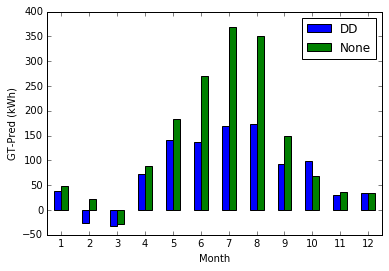

In [184]:
pd.DataFrame(a).plot(kind="bar",rot=0)
plt.xlabel("Month")
plt.ylabel("GT-Pred (kWh)")
plt.savefig('../results/transform_strategy_hvac.png')